# Prétraitement des Données d'Incendies - PACA & Nouvelle-Aquitaine

Ce notebook prépare les données brutes issues du BDIFF (base de données des incendies de forêt) pour deux régions françaises :
- **Nouvelle-Aquitaine (NA)**
- **Provence-Alpes-Côte d'Azur (PACA)**

Les étapes suivantes seront réalisées :
- Chargement des jeux de données nettoyés
- Harmonisation des colonnes
- Traitement des valeurs manquantes
- Nettoyage des colonnes non pertinentes
- Uniformisation des types de données (entiers, chaînes, etc.)
- Export des fichiers finaux préparés

### 1. Importation des bibliothèques nécessaires

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

### 2. Chargement des données incendies par région

Les fichiers utilisés ici proviennent d'une extraction filtrée et standardisée du **BDIFF**  
(Base de Données des Incendies de Forêt) pour les régions **Nouvelle-Aquitaine** et **PACA**.

Chaque fichier a été **pré-enrichi** avec des informations complémentaires, notamment :

- Les **coordonnées géographiques** (latitude, longitude) de la commune de l'incendie, obtenues par croisement avec les codes INSEE  
  à partir des jeux de données fournis par [La Poste - Datanova](https://datanova.laposte.fr) et via l’API [api-adresse.data.gouv.fr](https://api.gouv.fr/les-api/api-adresse) 
- La **station météorologique la plus proche**, identifiée par calcul de la distance géographique entre chaque commune et les stations météo
- Un **identifiant unique** (`id`) attribué à chaque incendie pour faciliter les croisements entre bases de données

Ces enrichissements permettent une intégration plus fluide avec les données météorologiques, et facilitent les analyses spatiales et temporelles.

In [4]:
df_na= pd.read_csv(r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\final\incendies\Incendies_Nouvelle_Aquitaine.csv", sep=";", encoding="utf-8-sig")
df_paca= pd.read_csv(r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\final\incendies\Incendies_PACA.csv", sep=";", encoding="utf-8-sig")

### 3. Nettoyage des noms de colonnes

Afin d’harmoniser la structure des deux jeux de données (`Nouvelle-Aquitaine` et `PACA`), nous appliquons les transformations suivantes :

- Suppression des espaces en début et fin de chaque nom de colonne (`.strip()`)
- Conversion des noms en minuscules (`.lower()`)
- Remplacement des espaces par des underscores (`.replace(" ", "_")`)
- Renommage de la colonne `id` en `id_incendie` pour garantir une clé unique cohérente entre les deux fichiers

Ces étapes permettent de faciliter la manipulation ultérieure des DataFrames et d’éviter toute ambigüité dans les noms de colonnes.


In [5]:
# Nettoyage des noms de colonnes
df_na.columns = df_na.columns.str.strip().str.lower().str.replace(" ", "_")
df_paca.columns = df_paca.columns.str.strip().str.lower().str.replace(" ", "_")

# Renommage de la colonne 'id' en 'id_incendie'
df_na = df_na.rename(columns={'id': 'id_incendie'})
df_paca = df_paca.rename(columns={'id': 'id_incendie'})

print("Colonnes Nouvelle-Aquitaine :")
print(df_na.columns)
print("\nColonnes PACA :")
print(df_paca.columns)

Colonnes Nouvelle-Aquitaine :
Index(['id_incendie', 'année', 'département', 'station', 'code_insee',
       'nom_de_la_commune', 'latitude', 'longitude', 'date_de_première_alerte',
       'surface_parcourue_(m2)', 'surface_forêt_(m2)',
       'surface_maquis_garrigues_(m2)',
       'autres_surfaces_naturelles_hors_forêt_(m2)', 'surfaces_agricoles_(m2)',
       'autres_surfaces_(m2)', 'surface_autres_terres_boisées_(m2)',
       'surfaces_non_boisées_naturelles_(m2)',
       'surfaces_non_boisées_artificialisées_(m2)',
       'surfaces_non_boisées_(m2)', 'précision_des_surfaces',
       'type_de_peuplement', 'nature', 'décès_ou_bâtiments_touchés',
       'nombre_de_décès', 'nombre_de_bâtiments_totalement_détruits',
       'nombre_de_bâtiments_partiellement_détruits', 'précision_de_la_donnée'],
      dtype='object')

Colonnes PACA :
Index(['id_incendie', 'année', 'département', 'station', 'code_insee',
       'nom_de_la_commune', 'latitude', 'longitude', 'date_de_première_alerte',
      

### 4. Vérification finale et conversion uniforme des dates
Bien que les dates aient été préalablement nettoyées et formatées, cette étape permet de :

- ***Vérifier*** qu'aucune valeur invalide ne subsiste dans la colonne `date_de_première_alerte`,
- ***Uniformiser*** le format en `YYYY-MM-DD HH:MM:SS` grâce à `pd.to_datetime()`.

Cela garantit que toutes les dates sont compatibles avec les analyses temporelles à venir (par jour, heure, mois ou saison).

In [18]:
def verifier_conversion_date(df, nom_colonne_date):
    # Nettoyage des espaces
    df[nom_colonne_date] = df[nom_colonne_date].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
    
    # Conversion directe de la colonne existante
    df[nom_colonne_date] = pd.to_datetime(df[nom_colonne_date], errors='coerce')
    
    # Vérification
    nb_erreurs = df[nom_colonne_date].isna().sum()
    print(f"Nombre de dates invalides : {nb_erreurs}")
    
    if nb_erreurs > 0:
        erreurs = df[df[nom_colonne_date].isna()]
        print("Lignes avec format de date incorrect (affichage brut) :")
        print(erreurs[nom_colonne_date].dropna().unique()[:5])
    else:
        print("Toutes les dates ont été converties correctement !")
    
    return df


# Appliquer à la NA
print("\nVérification pour Nouvelle-Aquitaine")
df_na = verifier_conversion_date(df_na, "date_de_première_alerte")

# Appliquer à la PACA
print("\nVérification pour PACA")
df_paca = verifier_conversion_date(df_paca, "date_de_première_alerte")

print(df_na[['date_de_première_alerte']].sample(5))
print(df_paca[['date_de_première_alerte']].sample(5))


Vérification pour Nouvelle-Aquitaine
Nombre de dates invalides : 0
Toutes les dates ont été converties correctement !

Vérification pour PACA
Nombre de dates invalides : 0
Toutes les dates ont été converties correctement !
     date_de_première_alerte
149      2010-04-10 17:33:00
5379     2022-04-03 17:58:00
1700     2012-06-26 19:03:00
223      2010-04-20 17:17:00
1786     2012-08-16 18:01:00
     date_de_première_alerte
2299     2016-04-12 15:34:00
5265     2021-08-07 17:54:00
167      2010-07-26 12:00:00
5640     2022-03-24 15:38:00
6333     2023-02-12 17:20:00


### 5. Analyse des valeurs manquantes
Avant d'entamer toute analyse descriptive ou exploratoire, il est essentiel d'évaluer la qualité des données.
Cette étape permet notamment d’identifier les colonnes contenant un taux élevé de valeurs manquantes, pouvant impacter les résultats ou nécessiter un prétraitement spécifique (suppression, imputation, etc.).

- La fonction ci-dessous calcule pour chaque colonne :

- le pourcentage de valeurs manquantes,

- le nombre absolu de valeurs manquantes,
tout en affichant un barplot clair pour visualiser rapidement les colonnes concernées.

In [33]:
def taux_valeurs_manquantes(
    df: pd.DataFrame, 
    nom_dataset: str = "Dataset",
    chemin_graph: Optional[str] = None
) -> pd.DataFrame:
    """
    Calcule et affiche le taux de valeurs manquantes par colonne,
    retourne un DataFrame des résultats, et affiche un graphique.
    
    Args:
        df (pd.DataFrame): Le DataFrame à analyser
        nom_dataset (str): Nom du dataset (pour titre/affichage)
        chemin_graph (str): Chemin d'enregistrement du graphique (.png)
    
    Returns:
        pd.DataFrame: DataFrame avec colonnes, % et nb de valeurs manquantes
    """
    
    # Calcul des statistiques
    missing_stats = pd.DataFrame({
        'Colonne': df.columns,
        '% Valeurs manquantes': (df.isnull().mean() * 100).round(2),
        'Nb valeurs manquantes': df.isnull().sum()
    }).sort_values('% Valeurs manquantes', ascending=False)

    # Affichage texte
    print(f"\n=== Taux de valeurs manquantes ({nom_dataset}) ===")
    print(f"Nombre total d'enregistrements : {len(df)}")
    print(missing_stats.to_string(index=False))

    # --- Graphique amélioré ---
    plt.figure(figsize=(10, max(6, 0.3 * len(missing_stats))))
    
    # Création du barplot avec des améliorations
    ax = sns.barplot(
        data=missing_stats,
        y='Colonne',
        x='% Valeurs manquantes',
        color='firebrick',  # Couleur unie plus élégante
        alpha=0.7,          # Légère transparence
        saturation=0.8      # Saturation légèrement réduite
    )
    
    # Ajout des valeurs sur les barres
    for p in ax.patches:
        width = p.get_width()
        if width > 0:  # N'affiche pas les étiquettes pour les barres de largeur 0
            ax.text(width + 1, 
                   p.get_y() + p.get_height()/2., 
                   f'{width:.1f}%', 
                   ha='left', 
                   va='center',
                   fontsize=9)
    
    # Amélioration des titres et labels
    plt.title(f'Taux de valeurs manquantes - {nom_dataset}\n', 
              fontsize=14, pad=20, fontweight='semibold')
    plt.xlabel('% de valeurs manquantes', fontsize=11, labelpad=10)
    plt.ylabel('Colonnes', fontsize=11, labelpad=10)
    
    # Amélioration des ticks et grid
    plt.xlim(0, 100)
    plt.xticks(ticks=range(0, 101, 10)), 
    plt.grid(axis='x', linestyle=':', alpha=0.4)
    
    # Style général
    sns.despine(left=True)  # Enlève le bord gauche
    plt.gca().spines['bottom'].set_color('#cccccc')  # Gris léger pour le bas
    
    # Ajustement final
    plt.tight_layout()

    # Sauvegarde optionnelle
    if chemin_graph:
        os.makedirs(os.path.dirname(chemin_graph), exist_ok=True)
        plt.savefig(chemin_graph, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return missing_stats

#### 5.1. Analyse des valeurs manquantes pour la Nouvelle-Aquitaine


=== Taux de valeurs manquantes (Nouvelle-Aquitaine) ===
Nombre total d'enregistrements : 6435
                                   Colonne  % Valeurs manquantes  Nb valeurs manquantes
             surface_maquis_garrigues_(m2)                100.00                   6435
                        type_de_peuplement                100.00                   6435
                    précision_de_la_donnée                 99.86                   6426
                           nombre_de_décès                 92.84                   5974
   nombre_de_bâtiments_totalement_détruits                 92.84                   5974
nombre_de_bâtiments_partiellement_détruits                 92.84                   5974
                      autres_surfaces_(m2)                 91.33                   5877
                   surfaces_agricoles_(m2)                 91.16                   5866
      surfaces_non_boisées_naturelles_(m2)                 84.48                   5436
 surfaces_non_boisées_art

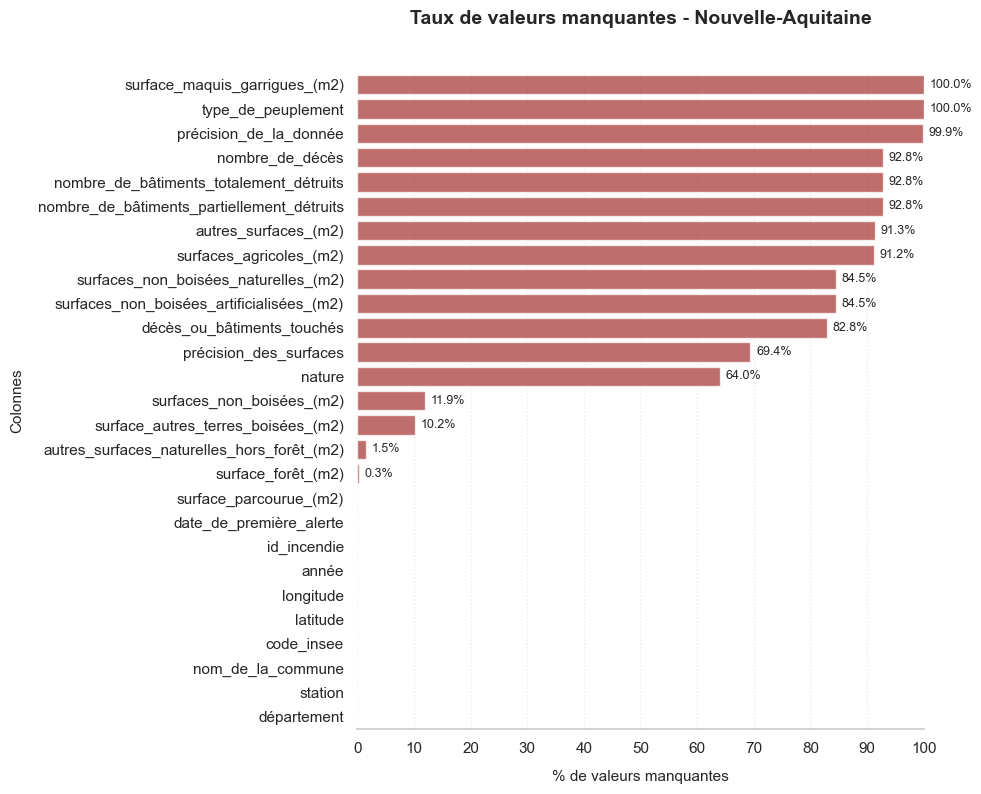

In [34]:
# Nouvelle-Aquitaine
na_missing = taux_valeurs_manquantes(
    df_na, 
    nom_dataset="Nouvelle-Aquitaine", 
    chemin_graph=None  
)

##### Données de la région Nouvelle-Aquitaine

- Plusieurs colonnes présentent **un taux de valeurs manquantes très élevé** :
  - `surface_maquis_garrigues_(m2)`, `type_de_peuplement` : **100 % de valeurs manquantes**
  - D'autres colonnes comme `précision_de_la_donnée`, `nombre_de_décès`, `nombre_de_bâtiments détruits` ou `surfaces agricoles` ont plus de **90 % de valeurs manquantes**.
- Environ **12 % de valeurs manquantes** dans `surfaces_non_boisées_(m2)`.
- Seules les colonnes **géographiques, temporelles et d'identification** (`longitude`, `latitude`, `id_incendie`, `station`, etc.) sont **complètes**.
- La colonne `surface_parcourue_(m2)` (surface totale brûlée) est **entièrement renseignée** 

#### 5.2. Analyse des valeurs manquantes pour la Provence-Alpes-Côte d'Azur 


=== Taux de valeurs manquantes (PACA) ===
Nombre total d'enregistrements : 7530
                                   Colonne  % Valeurs manquantes  Nb valeurs manquantes
        surface_autres_terres_boisées_(m2)                100.00                   7530
 surfaces_non_boisées_artificialisées_(m2)                100.00                   7530
      surfaces_non_boisées_naturelles_(m2)                100.00                   7530
   nombre_de_bâtiments_totalement_détruits                 95.33                   7178
nombre_de_bâtiments_partiellement_détruits                 95.33                   7178
                           nombre_de_décès                 95.33                   7178
                    précision_de_la_donnée                 94.85                   7142
autres_surfaces_naturelles_hors_forêt_(m2)                 83.80                   6310
                      autres_surfaces_(m2)                 83.80                   6310
                   surfaces_agricoles_(

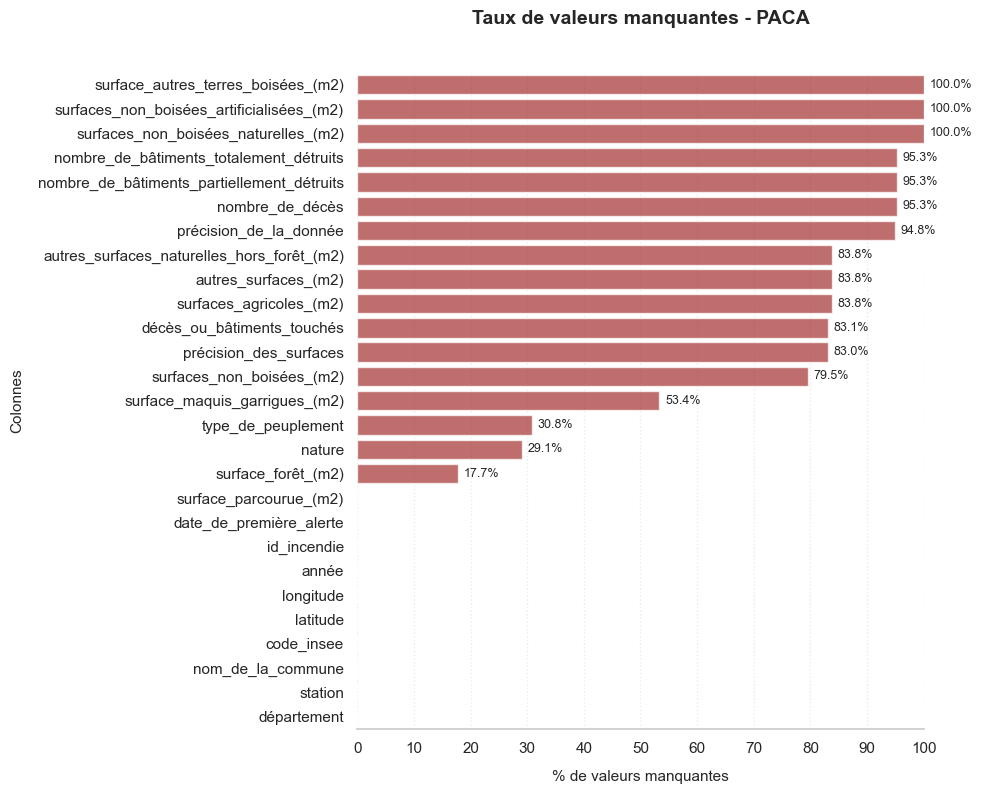

In [35]:
# PACA
paca_missing = taux_valeurs_manquantes(
    df_paca, 
    nom_dataset="PACA", 
    chemin_graph=None
)

##### Données de la région PACA

- Certaines colonnes ont également **100 % de valeurs manquantes** :
  - `surface_autres_terres_boisées_(m2)`, `surfaces_non_boisées_artificialisées_(m2)`, etc.
- Plus de **95 % de valeurs manquantes** pour les colonnes relatives aux **dommages humains et matériels** (`nombre_de_décès`, `bâtiments détruits`).
- Des variables importantes comme `surface_forêt_(m2)` sont **partiellement renseignées** (~18 % de valeurs manquantes).
- Les colonnes essentielles (`id_incendie`, `longitude`, `date_de_première_alerte`, etc.) sont **complètes**.
- Comme pour la NA, `surface_parcourue_(m2)` est **entièrement présente** 
---

### Analyse Stratégique des Valeurs Manquantes - Incendies Forestiers


#### Colonnes de surface

- Les deux fichiers (PACA et Nouvelle-Aquitaine) présentent un **taux élevé de valeurs manquantes** dans les colonnes de surface (`surface_broussailles`, `surface_forêts`, etc.).
- D’après la documentation officielle de la base BDIFF :
  - Une valeur **NaN** indique l'**absence de ce type de végétation** dans la zone brûlée.
  - Une valeur **0** signifie que la végétation ou les bâtiments étaient présents mais **n'ont pas été touchés**.
- **Conclusion** : ces valeurs ne sont **pas à imputer**, mais doivent être **interprétées avec précaution**. Elles ne représentent pas des données manquantes au sens classique.

#### Colonnes liées aux dégâts matériels et humains

| Colonne                                           | Traitement appliqué                                        |
|---------------------------------------------------|-------------------------------------------------------------|
| `nombre_de_décès`                                 | Très peu de valeurs renseignées → remplacées par `0`.       |
| `nombre_de_bâtiments_totalement_détruits`         | Très peu de valeurs renseignées → remplacées par `0`.       |
| `nombre_de_bâtiments_partiellement_détruits`      | Très peu de valeurs renseignées → remplacées par `0`.       |
| `décès_ou_bâtiments_touchés`                      | Incohérences (`oui` / `non`) + >80% de valeurs manquantes → **supprimée**. |

#### Autres colonnes

- `nature` : NaN remplacés par **"Non précisé"** pour permettre l’analyse catégorielle.
- `précision_de_la_donnée`, `précision_des_surfaces` : plus de 80 % de valeurs manquantes → **colonnes supprimées**.
- Les autres colonnes sont **bien remplies** et prêtes pour l’analyse descriptive.

#### Résumé

Ce nettoyage permet de :
- Conserver l’information pertinente,
- Éviter les imputations biaisées,
- Simplifier l’analyse statistique tout en respectant le sens original des données.
---

#### 6. Nettoyage des colonnes inutiles et des valeurs manquantes

- Les colonnes **'type_de_peuplement'**, **'décès_ou_bâtiments_touchés'** et **'précision_de_la_donnée'** seront supprimées, car elles sont inutilisables.
- Pour la colonne **'nature'**, les valeurs NaN seront remplacées par **"Non précisé"** afin de permettre l'analyse.
- Concernant les colonnes relatives aux dégâts (décès, bâtiments détruits), les valeurs NaN seront remplacées par **0**, conformément à la signification indiquée dans la documentation BDIFF.


In [ ]:
# 1. Supprimer les colonnes inutiles ou vides
# Nettoyage des colonnes vides ou partiellement renseignées
colonnes_a_supprimer = [
    "type_de_peuplement",
    "décès_ou_bâtiments_touchés",
    "précision_de_la_donnée",
    "précision_des_surfaces"
]

df_na.drop(columns=colonnes_a_supprimer, inplace=True, errors='ignore')
df_paca.drop(columns=colonnes_a_supprimer, inplace=True, errors='ignore')

# Remplacer les NaN dans 'nature' par "Non précisé"
df_na['nature'] = df_na['nature'].fillna("Non précisé")
df_paca['nature'] = df_paca['nature'].fillna("Non précisé")

# Colonnes de dégâts : NaN → 0, puis conversion en int
colonnes_degats = [
    "nombre_de_décès",
    "nombre_de_bâtiments_totalement_détruits",
    "nombre_de_bâtiments_partiellement_détruits"
]

for col in colonnes_degats:
    df_na[col] = df_na[col].fillna(0).astype(int)
    df_paca[col] = df_paca[col].fillna(0).astype(int)

#### 7. Vérification de l'intégrité des données de surface
Certaines surfaces doivent être des entiers (ou NaN). Cette étape vérifie la cohérence de ces colonnes.

In [43]:
colonnes_surfaces = [
    "surface_forêt_(m2)",
    "surface_maquis_garrigues_(m2)",
    "autres_surfaces_naturelles_hors_forêt_(m2)",
    "surfaces_agricoles_(m2)",
    "autres_surfaces_(m2)",
    "surface_autres_terres_boisées_(m2)",
    "surfaces_non_boisées_naturelles_(m2)",
    "surfaces_non_boisées_artificialisées_(m2)",
    "surfaces_non_boisées_(m2)"
]
print("Vérification des types et des valeurs dans les colonnes de surface de NA :\n")

for col in colonnes_surfaces:
    print(f"Colonne : {col}")
    print(f"Type : {df_na[col].dtype}")
    print(f"Exemples : {df_na[col].dropna().unique()[:5]}")
    print("-" * 50)

print("Vérification des types et des valeurs dans les colonnes de surface de PACA :\n")

for col in colonnes_surfaces:
    print(f"Colonne : {col}")
    print(f"Type : {df_paca[col].dtype}")
    print(f"Exemples : {df_paca[col].dropna().unique()[:5]}")
    print("-" * 50)


Vérification des types et des valeurs dans les colonnes de surface de NA :

Colonne : surface_forêt_(m2)
Type : Int64
Exemples : <IntegerArray>
[10, 5000, 2500, 0, 10000]
Length: 5, dtype: Int64
--------------------------------------------------
Colonne : surface_maquis_garrigues_(m2)
Type : Int64
Exemples : <IntegerArray>
[]
Length: 0, dtype: Int64
--------------------------------------------------
Colonne : autres_surfaces_naturelles_hors_forêt_(m2)
Type : Int64
Exemples : <IntegerArray>
[0, 2, 4, 10000, 500]
Length: 5, dtype: Int64
--------------------------------------------------
Colonne : surfaces_agricoles_(m2)
Type : Int64
Exemples : <IntegerArray>
[0, 430383, 13100, 310500, 175124]
Length: 5, dtype: Int64
--------------------------------------------------
Colonne : autres_surfaces_(m2)
Type : Int64
Exemples : <IntegerArray>
[0, 1500, 500, 16960, 5000]
Length: 5, dtype: Int64
--------------------------------------------------
Colonne : surface_autres_terres_boisées_(m2)
Type : 

#### 8. Conversion des surfaces en entiers
Toutes les colonnes de surface sont converties en entiers avec prise en charge des valeurs manquantes (type `Int64` de Pandas).


In [44]:
for col in colonnes_surfaces:
    # Vérification sur df_na
    non_entiers_na = df_na[col].dropna()[df_na[col] % 1 != 0]
    
    # Vérification sur df_paca
    non_entiers_paca = df_paca[col].dropna()[df_paca[col] % 1 != 0]
    
    if not non_entiers_na.empty or not non_entiers_paca.empty:
        print(f"Attention : valeurs non entières détectées dans la colonne '{col}'")
        if not non_entiers_na.empty:
            print(f"  - df_na : {non_entiers_na.unique()}")
        if not non_entiers_paca.empty:
            print(f"  - df_paca : {non_entiers_paca.unique()}")
    else:
        print(f"Colonne '{col}' : toutes les valeurs sont entières ou NaN")

Colonne 'surface_forêt_(m2)' : toutes les valeurs sont entières ou NaN
Colonne 'surface_maquis_garrigues_(m2)' : toutes les valeurs sont entières ou NaN
Colonne 'autres_surfaces_naturelles_hors_forêt_(m2)' : toutes les valeurs sont entières ou NaN
Colonne 'surfaces_agricoles_(m2)' : toutes les valeurs sont entières ou NaN
Colonne 'autres_surfaces_(m2)' : toutes les valeurs sont entières ou NaN
Colonne 'surface_autres_terres_boisées_(m2)' : toutes les valeurs sont entières ou NaN
Colonne 'surfaces_non_boisées_naturelles_(m2)' : toutes les valeurs sont entières ou NaN
Colonne 'surfaces_non_boisées_artificialisées_(m2)' : toutes les valeurs sont entières ou NaN
Colonne 'surfaces_non_boisées_(m2)' : toutes les valeurs sont entières ou NaN


In [45]:
for col in colonnes_surfaces:
    df_na[col] = df_na[col].astype("Int64")
    df_paca[col] = df_paca[col].astype("Int64")

print("Toutes les colonnes de surfaces ont été converties en entiers (avec NaN conservés).")

Toutes les colonnes de surfaces ont été converties en entiers (avec NaN conservés).


#### 9. Sauvegarde des fichiers nettoyés
Les jeux de données finaux sont enregistrés dans des fichiers `.csv` prêts pour l’analyse descriptive.

In [46]:
chemin_na = r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_nettoyes_na.csv"
chemin_paca = r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_nettoyes_paca.csv"

# Sauvegarder les fichiers
df_na.to_csv(chemin_na, index=False, sep=";", encoding="utf-8-sig")
df_paca.to_csv(chemin_paca, index=False,sep=";", encoding="utf-8-sig")

print("Fichiers sauvegardés avec succès :")
print(f"- {chemin_na}")
print(f"- {chemin_paca}")

Fichiers sauvegardés avec succès :
- C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_nettoyes_na.csv
- C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_nettoyes_paca.csv
